# An `asyncio` application

François-David Collin (CNRS, IMAG, Paul-Valéry Montpellier 3
University)  
Wednesday, August 27, 2025

## Simple *Hello world* example

Just make an asyncio coroutine which displays *Hello* and *world* with a
1 second delay in between and then await it.

In [3]:
import asyncio


async def hello():
    print("Hello")
    await asyncio.sleep(1)
    print("world")


await hello()

Hello
world

## `asyncio` queues

[Official doc](https://docs.python.org/3/library/asyncio-queue.html)

> asyncio queues are designed to be similar to classes of the queue
> module. Although asyncio queues are not thread-safe, they are designed
> to be used specifically in async/await code. Note that methods of
> asyncio queues don’t have a timeout parameter; use asyncio.wait_for()
> function to do queue operations with a timeout.

we have `put`/`get` coroutines for the queue.

## `asyncio` queues example

In [4]:
import asyncio

queue = asyncio.Queue()

await queue.put(1)
await queue.put(2)

print(await queue.get())
print(await queue.get())

1
2

# Producer/Consumer example

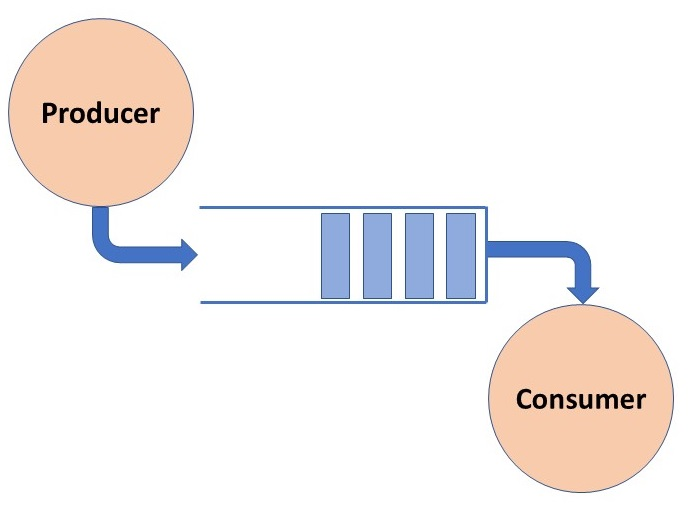

-   We want to produce, asynchronously, a sequence of integers and
    consume them as they are produced, also asynchronously.
-   Producing and consuming are two separate tasks, communicating
    through a queue.
-   We’ll arbitrarily slow down the producer by sleeping 1 second for
    each produced item.

The producer, once finished will produce a `None` in the queue, so that
the consumer knows it’s done.

## Pure `asyncio` solution

In [5]:
import asyncio

queue = asyncio.Queue()

async def produce(n):
    print("producing {} items".format(n))
    for x in range(1, n + 1):
        # simulate i/o operation using sleep
        . . .
        # produce an item
        print("producing {}/{}".format(x, n))
        item = str(x)
        # put the item in the queue
        . . .

    # indicate the producer is done
    . . .
    return n


async def consume():
    print("consuming items")
    consumed = 0
    while True:
        # wait for an item from the producer
        . . .
        # Handle the end of the production
        . . .
        # process the item
        print("consuming {}".format(item))
        consumed += 1
    return consumed

res = . . .
res

In [6]:
import asyncio

queue = asyncio.Queue()

async def produce(n):
    print("producing {} items".format(n))
    for x in range(1, n + 1):
        # simulate i/o operation using sleep
        await asyncio.sleep(1)
        # produce an item
        print("producing {}/{}".format(x, n))
        item = str(x)
        # put the item in the queue
        await queue.put(item)

    # indicate the producer is done
    await queue.put(None)
    return n


async def consume():
    print("consuming items")
    consumed = 0
    while True:
        # wait for an item from the producer
        item = await queue.get()
        if item is None:
            # the producer emits None to indicate that it is done
            break

        # process the item
        print("consuming {}".format(item))
        # simulate i/o operation using sleep
        consumed += 1
    return consumed

res = await asyncio.gather(
    produce(10),
    consume()
)
res

producing 10 items
consuming items
producing 1/10
consuming 1
producing 2/10
consuming 2
producing 3/10
consuming 3
producing 4/10
consuming 4
producing 5/10
consuming 5
producing 6/10
consuming 6
producing 7/10
consuming 7
producing 8/10
consuming 8
producing 9/10
consuming 9
producing 10/10
consuming 10

[10, 10]

## The same with threads

> **Caution**
>
> Threads doesn’t run coroutines directly. We need to use
> [`run_coroutine_threadsafe(coroutine,loop)`](https://docs.python.org/3/library/asyncio-task.html#asyncio.run_coroutine_threadsafe)
> to run a coroutine in a thread, dispatching it to the event loop. It
> returns a `Future` object that we can use to wait for the result of
> the coroutine.

For thread-safe queues, we can use the `queue` module from the standard
library (not `asyncio.Queue`).

In [7]:
import functools
from concurrent.futures import ThreadPoolExecutor
import asyncio
from queue import Queue

queue = Queue()
loop = asyncio.get_running_loop()

def produce(n):
    print("producing {} items".format(n))
    for x in range(1, n + 1):
        # simulate i/o operation using sleep
        . . .
        # produce an item
        print("producing {}/{}".format(x, n))
        item = str(x)
        # put the item in the queue
        . . .

    # indicate the producer is done
    . . .
    return n

def consume():
    consumed = 0
    print("consuming items")
    while True:
        # wait for an item from the producer
        . . .
        # Handle the end of the production
        . . .
        # process the item
        print("consuming {}".format(item))
        consumed += 1
    return consumed

with ThreadPoolExecutor() as pool:
    res = . . .
res

In [8]:
import functools
from concurrent.futures import ThreadPoolExecutor
import asyncio
from queue import Queue

queue = Queue()
loop = asyncio.get_running_loop()

def produce(n):
    print("producing {} items".format(n))
    for x in range(1, n + 1):
        # simulate i/o operation using sleep
        future = asyncio.run_coroutine_threadsafe(asyncio.sleep(1), loop)
        future.result()
        # produce an item
        print("producing {}/{}".format(x, n))
        item = str(x)
        # put the item in the queue
        queue.put(item)

    # indicate the producer is done
    queue.put(None)
    return n

def consume():
    consumed = 0
    print("consuming items")
    while True:
        # wait for an item from the producer
        item = queue.get()
        if item is None:
            # the producer emits None to indicate that it is done
            break

        # process the item
        print("consuming {}".format(item))
        consumed += 1
    return consumed

with ThreadPoolExecutor() as pool:
    res = await asyncio.gather(
        loop.run_in_executor(pool, functools.partial(produce, 10)),
        loop.run_in_executor(pool, functools.partial(consume))
    )
res

producing 10 items
consuming items
producing 1/10
consuming 1
producing 2/10
consuming 2
producing 3/10
consuming 3
producing 4/10
consuming 4
producing 5/10
consuming 5
producing 6/10
consuming 6
producing 7/10
consuming 7
producing 8/10
consuming 8
producing 9/10
consuming 9
producing 10/10
consuming 10

[10, 10]

## Aside, with decorators

We can (slighty) simplify the code by using decorators. Beware that the
`pool` object is closed by the `shutdown` method at the end, so the
decorator, which uses the pool as argument to the `run_in_executor`, is
no longer valid and the decorated functions are not usable anymore.

In [9]:
import functools
from concurrent.futures import ThreadPoolExecutor
import asyncio
from queue import Queue

queue = Queue()
loop = asyncio.get_running_loop()

pool = ThreadPoolExecutor(8)
def run_in_thread(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        return loop.run_in_executor(pool, functools.partial(func, *args, **kwargs))
    return wrapper

@run_in_thread
def produce(n):
    print("producing {} items".format(n))
    for x in range(1, n + 1):
        # simulate i/o operation using sleep
        future = asyncio.run_coroutine_threadsafe(asyncio.sleep(1), loop)
        future.result()
        # produce an item
        print("producing {}/{}".format(x, n))
        item = str(x)
        # put the item in the queue
        queue.put(item)

    # indicate the producer is done
    queue.put(None)
    return n

@run_in_thread
def consume():
    consumed = 0
    print("consuming items")
    while True:
        # wait for an item from the producer
        item = queue.get()
        if item is None:
            # the producer emits None to indicate that it is done
            break

        # process the item
        print("consuming {}".format(item))
        consumed += 1
    return consumed

res = await asyncio.gather(
    produce(10),
    consume()
)
pool.shutdown()
res

In [10]:
import asyncio
from queue import Queue

queue = Queue()
loop = asyncio.get_running_loop()

def produce(n):
    print("producing {} items".format(n))
    for x in range(1, n + 1):
        # simulate i/o operation using sleep
        future = asyncio.run_coroutine_threadsafe(asyncio.sleep(1), loop)
        future.result()
        # produce an item
        print("producing {}/{}".format(x, n))
        item = str(x)
        # put the item in the queue
        queue.put(item)

    # indicate the producer is done
    queue.put(None)
    return n

def consume():
    consumed = 0
    print("consuming items")
    while True:
        # wait for an item from the producer
        item = queue.get()
        if item is None:
            # the producer emits None to indicate that it is done
            break

        # process the item
        print("consuming {}".format(item))
        consumed += 1
    return consumed

res = await asyncio.gather(
    asyncio.to_thread(produce,10),
    asyncio.to_thread(consume)
)
res

## The same with processes

The queue is now a `multiprocessing.Queue`.

First do it normally, like previous example, observe the output.

Then add a `Lock` to protect the `print` statements.

The sleep is now a Python `sleep` (not `asyncio.sleep`).

``` python
#| eval: false
lock = Lock()

# inside a task
with lock:
    print("foo bar")
```

In [11]:
import functools
from concurrent.futures import ProcessPoolExecutor
import asyncio
from multiprocessing import Manager, Lock
from time import sleep

manager = Manager()
queue = manager.Queue()
loop = asyncio.get_running_loop()

def produce(queue, n):
    print("producing {} items".format(n))
    for x in range(1, n + 1):
        # simulate i/o operation using sleep
        . . .
        # produce an item
        print("producing {}/{}".format(x, n))
        item = str(x)
        # put the item in the queue
        . . .

    # indicate the producer is done
    . . .
    return n


def consume(queue):
    consumed = 0
    print("consuming items")
    while True:
        # wait for an item from the producer
        . . .
        # Handle the end of the production
        . . .
        # process the item
        print("consuming {}".format(item))
        consumed += 1
    return consumed

with ProcessPoolExecutor() as pool:
    res = . . .
res

In [12]:
import functools
from concurrent.futures import ProcessPoolExecutor
import asyncio
from multiprocessing import Manager, Lock
from time import sleep

manager = Manager()
queue = manager.Queue()
loop = asyncio.get_running_loop()

def produce(lock,queue, n):
    with lock:
        print("producing {} items".format(n))
    for x in range(1, n + 1):
        # simulate i/o operation using sleep
        sleep(1)
        # produce an item
        with lock:
            print("producing {}/{}".format(x, n))
        item = str(x)
        # put the item in the queue
        queue.put(item)

    # indicate the producer is done
    queue.put(None)
    return n


def consume(lock,queue):
    consumed = 0
    with lock:
        print("consuming items")
    while True:
        # wait for an item from the producer
        item = queue.get()
        if item is None:
            # the producer emits None to indicate that it is done
            break

        # process the item
        with lock:
            print("consuming {}".format(item))
        consumed += 1
    return consumed

with Manager() as manager:
    lock = manager.Lock()
    with ProcessPoolExecutor() as pool:
        res = await asyncio.gather(
            loop.run_in_executor(pool, functools.partial(produce, lock, queue, 10)),
            loop.run_in_executor(pool, functools.partial(consume, lock, queue))
        )
res

producing 10 items
producing 1/10
producing 2/10
producing 3/10
producing 4/10
producing 5/10
producing 6/10
producing 7/10
producing 8/10
producing 9/10
producing 10/10
consuming items
consuming 1
consuming 2
consuming 3
consuming 4
consuming 5
consuming 6
consuming 7
consuming 8
consuming 9
consuming 10

[10, 10]

## Exception Handling

**See also**

-   [set_exception_handler](https://docs.python.org/3/library/asyncio-eventloop.html#asyncio.loop.set_exception_handler)

``` python
def main():
    loop = asyncio.get_event_loop()
    # May want to catch other signals too
    signals = (signal.SIGHUP, signal.SIGTERM, signal.SIGINT)
    for s in signals:
        loop.add_signal_handler(
            s, lambda s=s: asyncio.create_task(shutdown(loop, signal=s))
        )
    loop.set_exception_handler(handle_exception)
    queue = asyncio.Queue()
```

## Testing with `pytest`

### Example:

``` python
import pytest

@pytest.mark.asyncio
async def test_consume(mock_get, mock_queue, message, create_mock_coro):
    mock_get.side_effect = [message, Exception("break while loop")]

    with pytest.raises(Exception, match="break while loop"):
        await consume(mock_queue)
```

### Third-party libraries

-   [pytest-asyncio](https://github.com/pytest-dev/pytest-asyncio) has
    helpfull things like fixtures for `event_loop`, `unused_tcp_port`,
    and `unused_tcp_port_factory`; and the ability to create your own
    [asynchronous
    fixtures](https://github.com/pytest-dev/pytest-asyncio/#async-fixtures).
-   [asynctest](https://asynctest.readthedocs.io/en/latest/index.html)
    has helpful tooling, including coroutine mocks and
    [exhaust_callbacks](https://asynctest.readthedocs.io/en/latest/asynctest.helpers.html#asynctest.helpers.exhaust_callbacks)
    so we don’t have to manually await tasks.
-   [aiohttp](https://docs.aiohttp.org/en/stable/) has some really nice
    built-in test utilities.

## Debugging

`asyncio` already has a [debug
mode](https://docs.python.org/3.6/library/asyncio-dev.html#debug-mode-of-asyncio)
in the standard library. You can simply activate it with the
`PYTHONASYNCIODEBUG` environment variable or in the code with
`loop.set_debug(True)`.

### Using the debug mode to identify slow async calls

`asyncio`’s debug mode has a tiny built-in profiler. When debug mode is
on, `asyncio` will log any asynchronous calls that take longer than 100
milliseconds.

### Debugging in oroduction with `aiodebug`

[aiodebug](https://github.com/qntln/aiodebug) is a tiny library for
monitoring and testing asyncio programs.

#### Example

``` python
from aiodebug import log_slow_callbacks


def main():
    loop = asyncio.get_event_loop()
    log_slow_callbacks.enable(0.05)
```

## Logging

[aiologger](https://github.com/b2wdigital/aiologger) allows non-blocking
logging.

## Asynchronous Widgets

**See also**

-   [Asynchronous
    Widgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Asynchronous.html)

In [13]:
def wait_for_change(widget, value):
    future = asyncio.Future()

    def getvalue(change):
        # make the new value available
        future.set_result(change.new)
        widget.unobserve(getvalue, value)

    widget.observe(getvalue, value)
    return future

In [14]:
from ipywidgets import IntSlider


slider = IntSlider()


async def f():
    for i in range(10):
        print("did work %s" % i)
        x = await wait_for_change(slider, "value")
        print("async function continued with value %s" % x)


asyncio.create_task(f())

slider